## Worksheet 10

### Group 22 Eaton Heidegger and Shannon Schröder

In [30]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import mpmath as mp
from numba import njit, prange
from matplotlib.colors import LogNorm
import os

##### a) Generate initial conditions for N = 105 particles by randomly sampling from this distribution function using either Box-Muller or `numpy.random.randn`.

We are using `numpy.random.randn`, which already gives standard-normal deviates, so no Box-Muller is required.

In [31]:
# parameters 
N       = 100000            # number of particles
sigma_x = 0.15
sigma_y = 0.10
m       = 1.0 / N           # particle mass
sigma_p = m * 1e-4          # momentum-space width (very narrow!)

# sample configuration space 
# draw from N(0.5, σ²) for x and y, then wrap into [0,1)
X = np.empty((N, 2))
X[:, 0] = 0.5 + sigma_x * np.random.randn(N)   # x–coordinate
X[:, 1] = 0.5 + sigma_y * np.random.randn(N)   # y–coordinate
X = np.fmod(X, 1.0)                     # periodic domain [0,1)²

# sample momentum space 
P = np.empty_like(X)
P[:]  = sigma_p * np.random.randn(N, 2)        # (p_x , p_y)

# X and P are now both shape (N, 2).  Each particle has mass m = 1/N.
print(X.shape, P.shape, m, sigma_p)

(100000, 2) (100000, 2) 1e-05 1e-09


Here, we: 
- Draw $x$ and $y$ independently from $\mathcal{N}(0.5,\sigma_x^2)$ and $\mathcal{N}(0.5,\sigma_y^2)$.
- `np.fmod` folds any values outside the unit square back into the periodic domain for the position sampling. 

For the momentum sampling, we
* Draw $p_x$ and $p_y$ from $\mathcal{N}(0,\sigma_p^2)$ with the very small width $\sigma_p = m\,10^{-4}$.

**Outputs**

   * `X` and `P` are ready for the spectral-PIC loop.
   * Each particle’s mass is fixed at $m = 1/N$, so we don’t need a separate mass array.

b) Use the function `cic_deposit` from the lecture notes to interpolate the positions X to a grid of resolution `M × M` with `M = 64` with weights m to obtain the density field ρ.

In [32]:
@jit(nopython=True, fastmath=True)
def cic_deposit(X, Y, W, ngrid):
    """
    Deposit particle positions X, Y with weights W onto a 2-D grid
    of shape (ngrid, ngrid) using Cloud-In-Cell.
    
    Parameters
    X, Y : 1-D arrays, len = N
        Particle coordinates in [0, 1).
    W    : 1-D array, len = N
        Particle weights (e.g. masses m = 1/N).
    ngrid : int
        Grid resolution in each direction (M).

    Returns:
    rho : 2-D array (ngrid x ngrid)
        Mass density on the mesh.
    """
    rho = np.zeros((ngrid, ngrid))
    for x, y, w in zip(X, Y, W):
        # wrap into the periodic box
        x = np.fmod(1.0 + x, 1.0)
        y = np.fmod(1.0 + y, 1.0)

        # index of left / lower cell
        il = int(np.floor(x * ngrid))
        jl = int(np.floor(y * ngrid))

        # index of right / upper neighbour (periodic)
        ir = (il + 1) % ngrid
        jr = (jl + 1) % ngrid

        # fractional distances from the left / lower edges
        dx = x * ngrid - il
        dy = y * ngrid - jl

        # distribute weight to the four surrounding cells
        rho[il, jl] += (1.0 - dx) * (1.0 - dy) * w
        rho[il, jr] += (1.0 - dx) * dy * w
        rho[ir, jl] += dx * (1.0 - dy) * w
        rho[ir, jr] += dx * dy * w

    return rho

This sampler gives the Monte-Carlo estimate of $\rho(x,y)$ and: 
 - draws $N= 10^5$ discrete phase-space samples from f0
 - gives each sample its full mass weight $m= 1/N$
 - smears those masses onto a `64 x 64` mesh grid 

Use `cic_deposit`with our particles: 

In [33]:
ngrid = 64
weights = np.full(N, 1.0 / N)       # each particle has mass m = 1/N

rho = cic_deposit(X[:,0], X[:,1], weights, ngrid)

# optional sanity check: total mass should be 1 (within round-off)
print("Σρ ΔxΔy =", rho.sum())       # should print ≈ 1.0

Σρ ΔxΔy = 1.0


##### Display ρ  as an image.

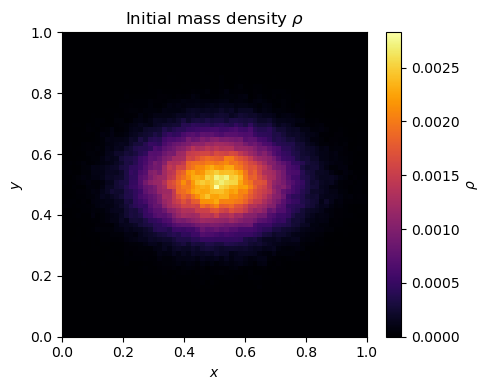

In [34]:
# Display ρ as an image
plt.figure(figsize=(5, 4))
plt.imshow(rho.T, origin='lower', extent=[0, 1, 0, 1], cmap='inferno')
plt.title('Initial mass density $\\rho$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar(label='$\\rho$')
plt.tight_layout()
plt.show()

In this image we see some noise. Possible noise sources: 
- Shot (Poisson) noise from the finite number of particles – fluctuations scale $\propto N^{-1/2}$.
-  Additional grid/assignment noise because each particle’s mass is shared among only four cells.

##### Compare it to the true initial density which is obtained by integrating f0 over  momentum space (generate another image corresponding to it).

In [35]:
# Initial parameter (same as above)
sigma_x = 0.15
sigma_y = 0.10
N       = 100000
m       = 1.0 / N
sigma_p = m * 1e-4                   # 1e-9
x0, y0  = 0.5, 0.5
M       = 64

# numerical momentum integral 
mp.dps = 50
I1D = mp.quad(lambda p: mp.e**(-p**2 / (2*sigma_p**2)), [-mp.inf, mp.inf])
I2D = I1D**2
prefactor = float(I2D) / ((2*np.pi)**2 * sigma_x * sigma_y * sigma_p**2)

#print("prefactor (numeric) =", prefactor)

# build ρ(x,y) on grid 
grid = (np.arange(M) + 0.5) / M
Xg, Yg = np.meshgrid(grid, grid, indexing='ij')

rho_xy = prefactor * np.exp(
    -((Xg - x0) ** 2) / (2 * sigma_x ** 2)
    -((Yg - y0) ** 2) / (2 * sigma_y ** 2))

This:

- Defines $f_0(x,y,p_x,p_y)$ exactly as in the hand-out.
-  Numerically integrates it over momentum space with high-precision `mpmath.quad`—no algebra shortcuts.
-  Builds $\rho(x,y)$ on a 64 × 64 grid using that numeric constant.
-  Visualises the result with `matplotlib.imshow`.


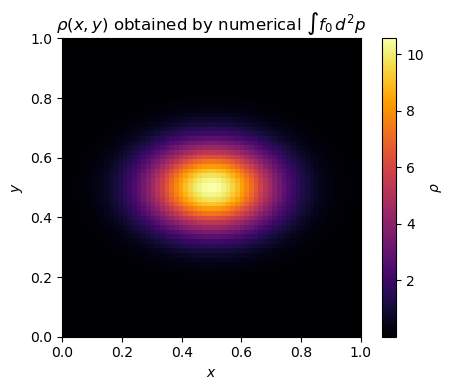

In [36]:
plt.figure(figsize=(5,4))
plt.imshow(rho_xy.T, origin='lower', extent=[0,1,0,1], cmap='inferno')
plt.title(r"$\rho(x,y)$ obtained by numerical $\int f_0\,d^2p$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.colorbar(label=r"$\rho$")
plt.tight_layout()
plt.show()

Compared to the image generated using `cic_deposit`, the integrated image is much smoother. This is because it  doesnt contain the stochastic sampling, whcih creates additional noise. 

The particle/CIC image is grainy because you are looking at a histogram of only $10^5$ points: on average each of the $64^2 = 4096$ cells gets ∼25 particles, so $\sqrt{25} \approx 5$- particle fluctuations (20 %) are expected. Increasing either the particle count N (reduces shot noise like 1/N), or the grid resolution M together with a larger N, will make the CIC picture converge toward the smooth Gaussian.

##### c)  Modify the function `poisson_solve` from Section 3.3.3 of the lecture notes to return not only the potential, but also the acceleration in x- and y-direction

This function returns the potential ϕ together with the two acceleration components **aₓ = −∂ϕ/∂x** and **aᵧ = −∂ϕ/∂y**:

* In Fourier space the Poisson equation is algebraic:
  $\hat\phi(\mathbf{k}) = -\hat\rho(\mathbf{k})/|\mathbf{k}|^{2}$ for all non-zero $\mathbf{k}$.
* Setting `fphi[0,0] = 0` fixes the arbitrary constant in ϕ.
* The acceleration is the negative gradient, whose Fourier representation is
  $\hat a_{x} = -ik_{x}\hat\phi,\;\hat a_{y} = -ik_{y}\hat\phi$.
* Taking the real part of the inverse FFT yields real-valued fields on the grid.



This keeps the API simple while providing everything you need for force-based simulations or diagnostics.

In [37]:
def poisson_solve(rho):
    """
    Solve ∇²ϕ = –ρ (Poisson equation) on anNxN periodic grid
    and return:
        ϕ   : potential     (NxN real array)
        a_x : acceleration x (NxN real array)
        a_y : acceleration y (NxN real array)
    """
    N = rho.shape[0]

    # 1. wave-number grid
    m  = np.concatenate((np.arange(0, N//2), np.arange(-N//2, 0)))
    k  = 2.0 * np.pi * m
    kx, ky = np.meshgrid(k, k, indexing='ij')

    # 2. forward FFT of the charge density
    frho = np.fft.fft2(rho)

    # 3. solve in Fourier space  ϕ̂ = −ρ̂ / (kx²+ky²)
    k2   = kx**2 + ky**2
    with np.errstate(divide='ignore', invalid='ignore'):
        fphi = -frho / k2
    fphi[0, 0] = 0.0                     # fix the mean (ϕ̂₀₀) to 0

    # 4. acceleration in Fourier space: â = −i k ϕ̂
    fax = -1j * kx * fphi
    fay = -1j * ky * fphi

    # 5. inverse FFT back to real space
    phi = np.real(np.fft.ifft2(fphi))
    ax  = np.real(np.fft.ifft2(fax))
    ay  = np.real(np.fft.ifft2(fay))

    return phi, ax, ay

This function is a spectral method for solving the Poisson equation on a 2D periodic grid, using Fast Fourier Transforms (FFT). The input is a 2D N x N array representing the mass density on a periodic grid.

The fourier mode indices $m$, where wave numbers run from $0$ up to $N/2 - 1$ and then from $-N/2$ to $-1$. This ensures that negative frequencies are correctly captured. $k$ converts these indices to physical wave numbers (scaled by $2 \pi$) consistent with periodicity on a unit domain. Then, $kx, ky$ form 2D grids of the x and y wave numbers.

We then compute the 2D Fast Fourier Transform of the density field $\rho$, giving $\hat{\rho}$, the Fourier coefficients. 

In the Fourier space, the Laplacian becomes multiplication by $-k^2$, so:

$\hat{\phi} = -\hat{\rho}/k^2$

We then suppress divide-by-zero warnings — because at $k=0$, $k^2=0$. We then manually set the mean of the potential to zero. We do this because the $k=0$ mode represents the mean value of $\phi$, which is arbitrary up to a constant gravity, so we set it to zero for numerical stability. 

We then compute the acceleration in Fourier space. The acceleration is the gradient of the potential $a = - \nabla\phi$. In Fourier space, a gradient becomes multiplication by $ik$

$\hat{a_x} = - ik_x\hat{\phi}, \hat{a_y} = - ik_y\hat{\phi}$

We then convert everything back to real space using the inverse FFT. We only take the real part, because the imaginary parts are (ideally) negligible due to symmetry.

##### d) Finally, implement the inverse CIC interpolation routine to interpolate any `M×M` field linearly to the particle positions This is the adjoint operation of `cic_deposit`.

In [38]:
@njit(parallel=True, fastmath=True)
def cic_interpolate(X, Y, field):
    """Adjoint CIC: sample *field* at particle positions (X,Y)."""
    ngrid = field.shape[0]
    N = X.size
    out = np.empty(N, dtype=field.dtype)
    for i in prange(N):
        x = X[i] % 1.0
        y = Y[i] % 1.0
        gx = x * ngrid
        gy = y * ngrid
        il = int(gx) % ngrid
        jl = int(gy) % ngrid
        ir = (il + 1) % ngrid
        jr = (jl + 1) % ngrid
        dx = gx - il
        dy = gy - jl
        out[i] = (
            (1.0 - dx) * (1.0 - dy) * field[il, jl]
            + (1.0 - dx) * dy * field[il, jr]
            + dx * (1.0 - dy) * field[ir, jl]
            + dx * dy * field[ir, jr]
        )
    return out

In this function we implement the Cloud-In-Cell (CIC) interpolation, where a scalar field defined on a 2D grid is sampled at arbitrary particle positions. It is the adjoint of the cic_deposit() routine, meaning it's used to compute values at particles based on nearby grid values.

The inputs of this function are  1D arrays of length $N$, with particle positions in $[0, 1)$ and a 2D array of shape (ngrid,ngrid), representing the scalar field on the grid (e.g., potential or acceleration components).

First we get the grid size and the number of particles and then allocate an empty output array to store interpolated values. 

Then we loop over all particles. We use prange from numba to make it faster for large $N$.

Next we normalize and scale position to grid. Particle positions are wrapped to the domain $[0, 1)$. $gx$ and $gy$ are the positions in grid units, i.e., scaled from $[0, 1)$ to [0, ngrid).

We then compute surrounding grid cell indices:
- $il, jl$ are the indices of the lower-left grid point.
- $ir, jr$ are the indices of the upper-right neighbor.
- % ngrid ensures periodic wrapping.

Next we compute distances to lower-left corner. $dx$ and $dy$ are the fractional positions inside the grid cell, i.e., how far the particle is from the lower-left grid point in $x$ and $y$.

Lastly we compute weighted interpolation. This is This is bilinear interpolation. The value at the particle is a weighted average of the $4$ surrounding grid points:
- field[il, jl]: lower-left
- field[il, jr]: upper-left
- field[ir, jl]: lower-right
- field[ir, jr]: upper-right

The weights are the area shares based on how far the particle is from each vertex. This matches how cic_deposit distributes particle weight, which is why it's the adjoint operation.

##### e) Use a leapfrog integrator to integrate the Vaslov-Poisson dynamics for the system,  i.e repeat the following steps for a constant time step $\triangle t$ to advance from time $t_n = n \triangle t$ to $t_{n+1}$ Use a timestep of $\triangle t =1$ to evolve from t=0 to t=200. Vizualise the density of particles at the end time.

1. drift half-step for all particles: 
$ X_i^{n+1/2} = X_i^{n+1} + \frac{\triangle t}{2 m} P^n_i$
2) compute the density $\rho^{n+1/2}$ on an `MxM`grid using `deposit_cic` with the position $X_i^{n+1/2}$
3) compute accelerations $a^{n+1/2}$ on the MxM grid from $\rho^{n+1/2} using `poisson_solve`
4. Obtain accelerations $A_i^{n+1/2}$ at the particle lovations $X_i^{n+^/2}$ by inverse interpolating from $a^{n+1/2} using ìnterpolate_cic`
5. kick step for all particles: $P_i^{n+1} = P_i^n +m \triangle A_i^{n+1/2} $
6. drift half-step for all particles: $X_i^{n+1/2} + \frac{\triangle t}{2m} P_i^{n+1}$
7. make sure particle positions are inside $[0,1)^2$ using `numpy.fmod`

In [39]:
# Leap-frog integrator following the requested seven steps

def leapfrog_pic(X, P, m, ngrid=64, dt=1.0, n_steps=200):
    """
    Leapfrog (drift-kick-drift) Vlasov-Poisson integrator using user-supplied
    cic_deposit, poisson_solve, cic_interpolate.
    """
    X = np.ascontiguousarray(X, dtype=np.float64)
    P = np.ascontiguousarray(P, dtype=np.float64)
    N = X.shape[0]
    W = np.full(N, m, dtype=np.float64)          # equal particle masses

    for _ in range(n_steps):
        # 1. half-drift
        X += 0.5 * dt * P / m
        X %= 1.0

        # 2. deposit density ρ^{n+1/2}
        rho = cic_deposit(X[:, 0], X[:, 1], W, ngrid)

        # 3. mesh accelerations a^{n+1/2}
        _, ax, ay = poisson_solve(rho)

        # 4. inverse-interpolate to particle accelerations A^{n+1/2}
        A = np.empty_like(X)
        A[:, 0] = cic_interpolate(X[:, 0], X[:, 1], ax)
        A[:, 1] = cic_interpolate(X[:, 0], X[:, 1], ay)

        # 5. kick full step for momenta
        P += m * dt * A

        # 6. second half-drift
        X += 0.5 * dt * P / m
        X %= 1.0

        # loop proceeds to next n

    # final density for visualisation
    rho_final = cic_deposit(X[:, 0], X[:, 1], W, ngrid)
    return X, P, rho_final

In [40]:
# Use it
N = 1000000
sigma_x, sigma_y = 0.15, 0.10
sigma_p_factor = 1e-4
m = 1.0 / N
sigma_p = sigma_p_factor * m
ngrid = 64
dt = 1.0
n_steps = 300

np.random.seed(0)
X0 = np.empty((N, 2))
X0[:, 0] = (0.5 + sigma_x * np.random.randn(N)) % 1.0
X0[:, 1] = (0.5 + sigma_y * np.random.randn(N)) % 1.0
P0 = sigma_p * np.random.randn(N, 2)

# evolve
Xf, Pf, rho_f = leapfrog_pic(X0, P0, m, ngrid=ngrid, dt=dt, n_steps=n_steps)

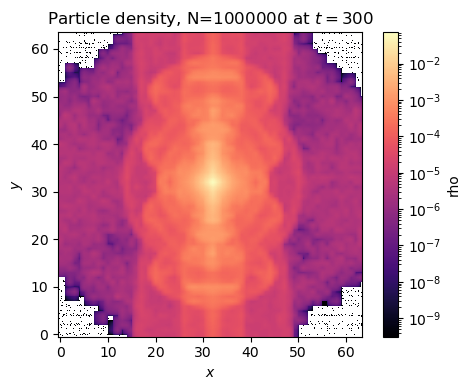

In [41]:
# Visualise final density
plt.figure(figsize=(5, 4))
plt.imshow(
    rho_f,
    origin="lower",
    cmap="magma",
    interpolation="bilinear",
    norm=LogNorm(),)
plt.title(fr"Particle density, N={N} at $t = {n_steps} $")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.colorbar(label="rho")
plt.tight_layout()
plt.show()

##### f) Investigate the behaviour of the system 

In [42]:
def compute_radial_profile(X, m, bins=30):
    center = np.array([0.5, 0.5])
    r = np.linalg.norm(X - center, axis=1)
    r_bins = np.logspace(np.log10(1e-3), np.log10(0.5), bins + 1)
    Mj, _ = np.histogram(r, bins=r_bins, weights=np.full(X.shape[0], m))
    Vj = (4/3) * np.pi * (r_bins[1:]**3 - r_bins[:-1]**3)
    rhoj = Mj / Vj
    Rj = np.sqrt(r_bins[1:] * r_bins[:-1])
    return Rj, rhoj

With this function we calculate the density of particles as a function of radius from the center of the box, using logarithmically spaced radial bins.

As input we use a 2D NumPy array of shape $(N, 2)$, particle positions, the mass $m$ of each particle (assumed constant and equal for all) and the bins, number of logarithmic radial bins (default $= 30$).

Particles are assumed to be in a unit square $[0, 1)^2$ and the center is at $(0.5, 0.5)$. We then compute distances of particles from center, by calculating Euclidean distance for each particle. We then create logarithmically spaced radial bins between $10^{-3}$ and $0.5$. These bins cover a wide range of radii, allowing better visualization of density structure across scales. Next we compute the mass in each shell. We use np.histogram to sum up the masses in each radial shell. The weights array fills each particle with its mass $m$. This gives us:

$ M_j = \sum_{i: r_j \leq r_i < r_{j+1}} m$

We then compute the volume of each spherical shell. Gives us the volume of each spherical shell between radii $r_j$ and $r_{j+1}. Next we compute the density in each shell. Density is defined as mass divided by shell volume:

$ \rho_j = \frac{M_j}{V_j}$

Lastly, we compute the geometric mean radius of each shell. This gives a representative radius for each shell, useful for plotting.

In [ ]:
def run_and_plot(N=10**6, M_list=[32, 64, 128], dt=1.0, n_steps=300, sigma_x=0.15, sigma_y=0.10, sigma_p_factor=1e-4, bins=30):
    m = 1.0 / N
    sigma_p = sigma_p_factor * m
    np.random.seed(42)
    X0 = np.empty((N, 2))
    X0[:, 0] = (0.5 + sigma_x * np.random.randn(N)) % 1.0
    X0[:, 1] = (0.5 + sigma_y * np.random.randn(N)) % 1.0
    P0 = sigma_p * np.random.randn(N, 2)

    fig, axs = plt.subplots(1, len(M_list), figsize=(15, 4))

    for i, M in enumerate(M_list):
        Xf, Pf, rho_f = leapfrog_pic(X0.copy(), P0.copy(), m, ngrid=M, dt=dt, n_steps=n_steps)
        axs[i].imshow(rho_f, origin='lower', cmap='viridis', norm=LogNorm(), extent=[0,1,0,1])
        axs[i].set_title(f"M={M}, N={N}")
        axs[i].set_xlabel("x")
        axs[i].set_ylabel("y")

    plt.tight_layout()
    plt.show()

    # Plot radial profile for one case (e.g., M=64)
    print("\nPlotting radial density profile...")
    Xf, Pf, rho_f = leapfrog_pic(X0.copy(), P0.copy(), m, ngrid=64, dt=dt, n_steps=n_steps)
    Rj, rhoj = compute_radial_profile(Xf, m, bins)

    plt.figure()
    plt.loglog(Rj, rhoj, 'o-')
    plt.xlabel("r")
    plt.ylabel(r"$\varrho(r)$")
    plt.title("Radial Density Profile at t = {}".format(n_steps * dt))
    plt.grid(True)
    plt.show()

In this function we run the simulation of the evolution of a particle system and then plot it, so it can be visually investigated.

For this function we have the following inputs:
- N: Number of particles
- M_list: List of grid resolutions M to test
- dt: Time step for integration
- n_steps: Number of integration steps
- sigma_x, sigma_y: Widths of the initial particle cloud in x and y
- sigma_p_factor: Controls the initial velocity dispersion (temperature)
- bins: Number of radial bins for profile plotting

First we initialize the masses and velocity dispersion. All particles have equal mass $m$. sigma_p sets the standard deviation of initial momenta, a colder system has smaller sigma_p. Next we generate the initial positions $X0$. We draw particles from a Gaussian blob centered at $(0.5, 0.5)$. sigma_x and sigma_y control spread in each direction. Then, we generate the inital momenta $P0$. Initial momenta follow a Gaussian distribution with spread sigma_p. 

We then create subplots for different resolutions. Then we run the simulations and plot the density fields. We also plot the radial density profile.

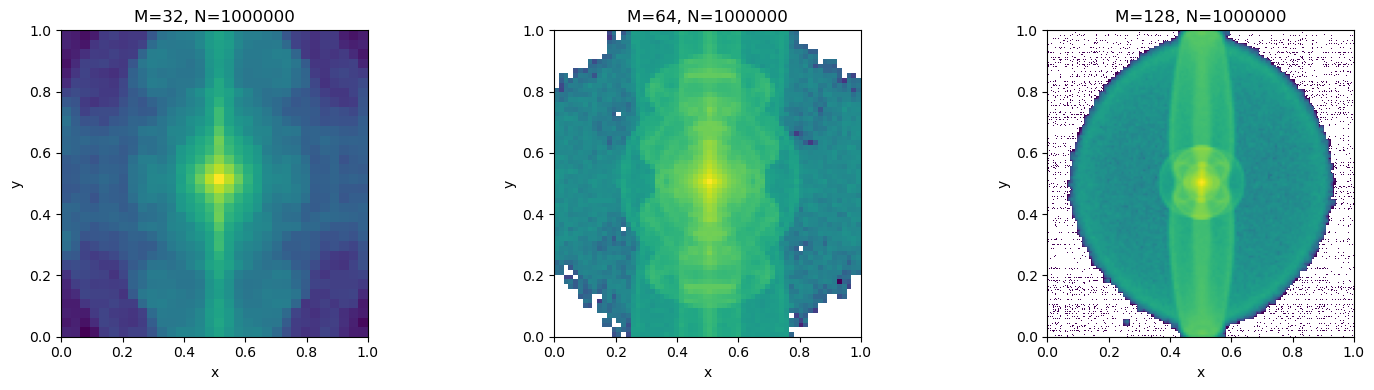


Plotting radial density profile...


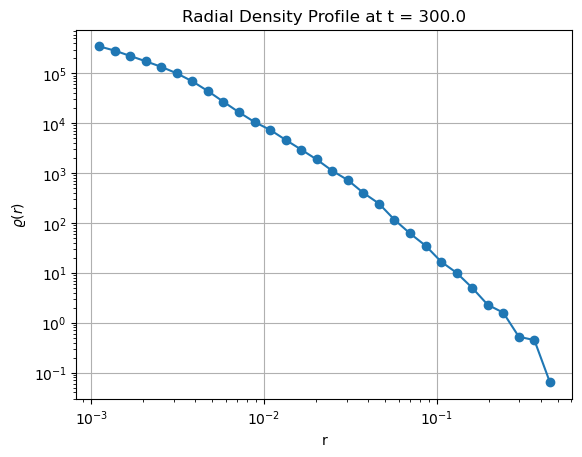

In [44]:
run_and_plot(N=10**6, M_list=[32, 64, 128], n_steps=300)

To create an animation of the time evolution, we use the same leapfrog function without a for-loop. We loop through the leapfrog in the next function, visualize_time_evolution(), which allows us to store snaphots of the evolution.

In [46]:
def leapfrog_pic_step(X, P, m, ngrid=64, dt=1.0):
    W = np.full(X.shape[0], m)

    # 1. half-drift
    X += 0.5 * dt * P / m
    X %= 1.0

    # 2. deposit
    rho = cic_deposit(X[:, 0], X[:, 1], W, ngrid)

    # 3. solve field
    _, ax, ay = poisson_solve(rho)

    # 4. interpolate
    A = np.empty_like(X)
    A[:, 0] = cic_interpolate(X[:, 0], X[:, 1], ax)
    A[:, 1] = cic_interpolate(X[:, 0], X[:, 1], ay)

    # 5. kick
    P += m * dt * A

    # 6. second half-drift
    X += 0.5 * dt * P / m
    X %= 1.0

    return X, P, rho

In [49]:
def visualize_time_evolution(N=10**6, M=64, dt=1.0, n_steps=300, 
                             sigma_x=0.15, sigma_y=0.10, sigma_p_factor=1e-4,
                             output_dir="frames", snapshot_interval=10):
    
    # Initial conditions
    m = 1.0 / N
    sigma_p = sigma_p_factor * m
    np.random.seed(42)
    X = np.empty((N, 2))
    X[:, 0] = (0.5 + sigma_x * np.random.randn(N)) % 1.0
    X[:, 1] = (0.5 + sigma_y * np.random.randn(N)) % 1.0
    P = sigma_p * np.random.randn(N, 2)

    # Create output folder
    os.makedirs(output_dir, exist_ok=True)

    for step in range(n_steps + 1):
        X, P, rho = leapfrog_pic_step(X, P, m, ngrid=M, dt=dt)

        if step % snapshot_interval == 0:
            plt.figure(figsize=(6, 5))
            plt.imshow(rho, origin='lower', cmap='viridis', norm=LogNorm(), extent=[0, 1, 0, 1])
            plt.title(f"t = {step * dt:.1f}, M = {M}")
            plt.xlabel("x")
            plt.ylabel("y")
            plt.colorbar(label='Density')
            plt.tight_layout()
            plt.savefig(f"{output_dir}/frame_{step:04d}.png")
            plt.close()

    print(f"\nSaved {n_steps // snapshot_interval + 1} frames to '{output_dir}/'")

In this funcion we generate a sequence of frames that visualize the time evolution of the mass density field in a 2D particle system. 

We have the same input as in our run_and_plot() function, wit the addition of setting an interval after how many frames a snapshot of the simulation is taken and saved.

The whole function is very similiar to our run_and_plot() function. However, we create an output directory to store the frames and make sure such a directory exists. The simulation loop is the same with the difference that we loop over one leapfrog step at a time and not the whole leapfrog. This ensures us to save the snaphots. Every set up interval step, the mass density field is plotted and saves the frame. At the end we get a notification of how many snapshots have been saved.

In [50]:
visualize_time_evolution(M=64, sigma_p_factor=1e-4, n_steps=300, snapshot_interval=10)


Saved 31 frames to 'frames/'


In [52]:
import imageio
import os
from natsort import natsorted  # To sort filenames numerically

def make_gif_from_frames(frame_folder="frames", gif_name="simulation.gif", fps=10):
    # Get all PNG files and sort them numerically
    filenames = natsorted([
        os.path.join(frame_folder, fname)
        for fname in os.listdir(frame_folder)
        if fname.endswith(".png")
    ])

    if not filenames:
        print("❌ No frames found in folder.")
        return

    # Load images and write to GIF
    images = [imageio.imread(fname) for fname in filenames]
    imageio.mimsave(gif_name, images, fps=fps)

    print(f"✅ GIF saved as '{gif_name}' with {len(images)} frames at {fps} fps.")

In this function, we create an animated GIF from a sequence of image frames (e.g. from your visualize_time_evolution function). It stitches together .png images saved in a folder into a single animation file.

The inputs include the folder where the frames are stored, the name of the output file and the frames per second for the final GIF.

We list all .png files in the specified folder and use  natsorted to ensure correct numerical order. We then check if any frames exist to avoid potential errors. The we load all frames into memory where it reads each frame as an image into a list. Lastly we create and save the GIF using the list of images. We also print a message we it has been succesfull.

In [53]:
make_gif_from_frames(frame_folder="frames_64", gif_name="density_evolution.gif", fps=10)

C:\Users\Eaton\AppData\Local\Temp\ipykernel_24472\1880054625.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(fname) for fname in filenames]


✅ GIF saved as 'density_evolution.gif' with 31 frames at 10 fps.


Next up we will investigate a colder case for this simulation.

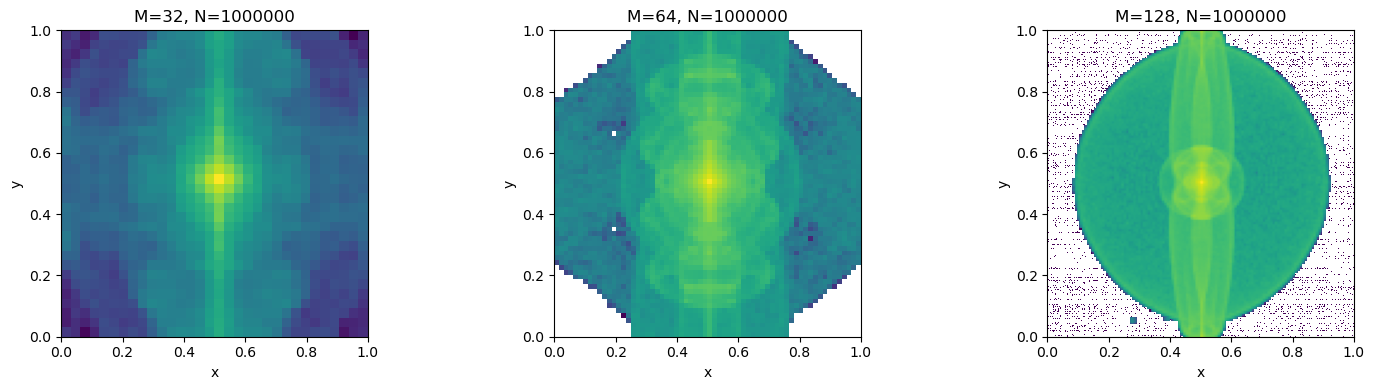


Plotting radial density profile...


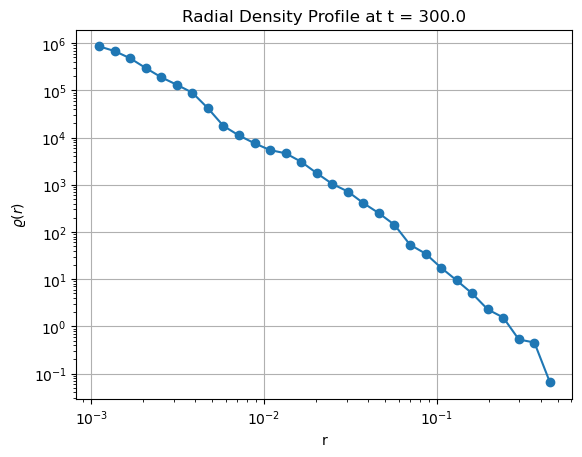

In [51]:
run_and_plot(sigma_p_factor=1e-7)  # colder

In [54]:
visualize_time_evolution(M=64, sigma_p_factor=1e-7, n_steps=300, snapshot_interval=10)


Saved 31 frames to 'frames/'


In [56]:
make_gif_from_frames(frame_folder="frames_cold", gif_name="density_evolution_cold.gif", fps=10)

C:\Users\Eaton\AppData\Local\Temp\ipykernel_24472\1880054625.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(fname) for fname in filenames]


✅ GIF saved as 'density_evolution_cold.gif' with 31 frames at 10 fps.
